In [3]:
import pandas as pd
import numpy as np

In [4]:
import scvi

/home/ouahbi/anaconda3/envs/sc_rnaseq/lib/python3.11/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/ouahbi/anaconda3/envs/sc_rnaseq/lib/python3.11/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [5]:
scvi.settings.seed = 0

Global seed set to 0


In [6]:
scvi.settings.pin_memory = True

In [7]:
import scanpy as sc

In [8]:
adata = sc.read_10x_h5('data/GSM5538778_MF18raw_feature_bc_matrix.h5')

/home/ouahbi/anaconda3/envs/sc_rnaseq/lib/python3.11/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/ouahbi/anaconda3/envs/sc_rnaseq/lib/python3.11/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [9]:
adata

AnnData object with n_obs × n_vars = 737280 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

# Doublet removal (need GPU)

In [10]:
"""sc.pp.filter_genes(adata, min_cells=10)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=True, flavor='seurat_v3')
scvi.model.SCVI.setup_anndata(adata)
vae = scvi.model.SCVI(adata)
vae.train()



solo = scvi.external.SOLO.from_scvi_model(vae)
solo.train()



df = solo.predict()
df['prediction'] = solo.predict(soft = False)

df.index = df.index.map(lambda x: x[:-2])

df"""

"sc.pp.filter_genes(adata, min_cells=10)\nsc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=True, flavor='seurat_v3')\nscvi.model.SCVI.setup_anndata(adata)\nvae = scvi.model.SCVI(adata)\nvae.train()\n\n\n\nsolo = scvi.external.SOLO.from_scvi_model(vae)\nsolo.train()\n\n\n\ndf = solo.predict()\ndf['prediction'] = solo.predict(soft = False)\n\ndf.index = df.index.map(lambda x: x[:-2])\n\ndf"

# Preprocessing

/home/ouahbi/anaconda3/envs/sc_rnaseq/lib/python3.11/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/ouahbi/anaconda3/envs/sc_rnaseq/lib/python3.11/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/ouahbi/anaconda3/envs/sc_rnaseq/lib/python3.11/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/ouahbi/anaconda3/envs/sc_rnaseq/lib/python3.11/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/ouahbi/anaconda3/envs/sc_rnaseq/lib/python3.11/site-packages/seaborn/_

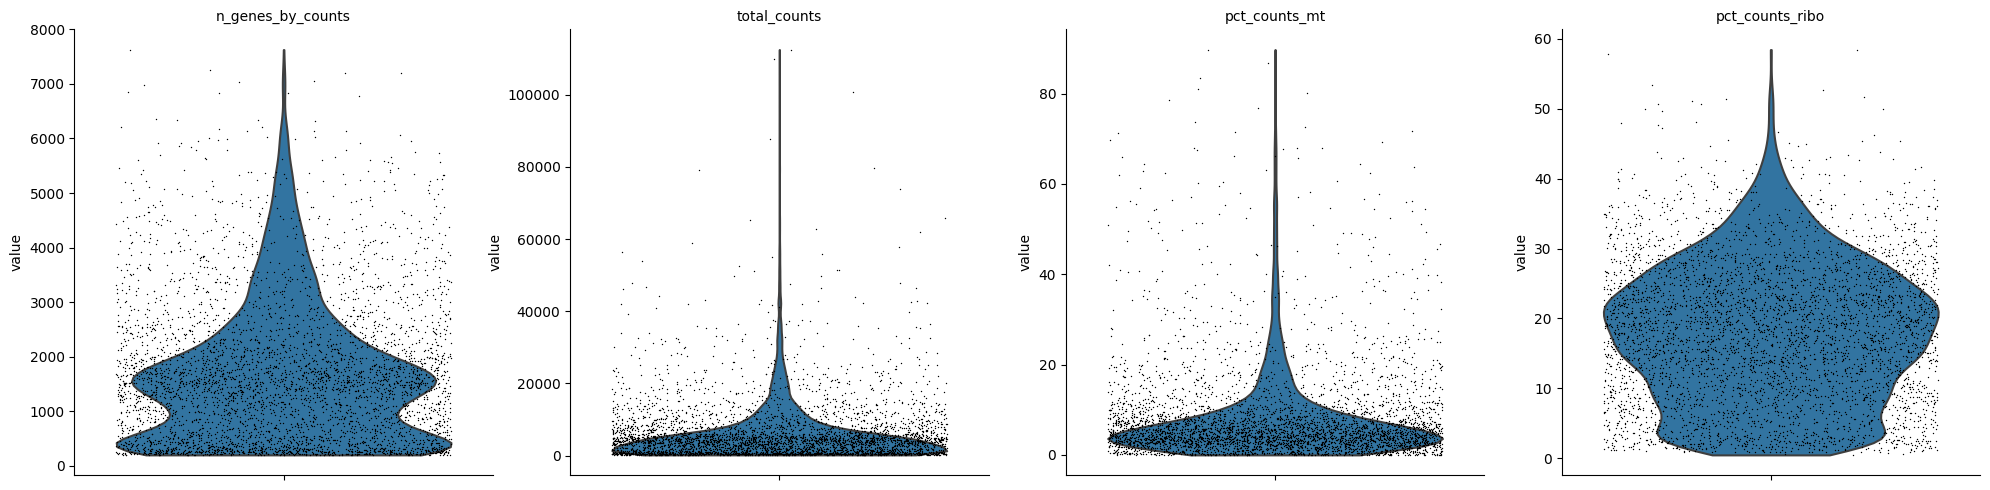

In [11]:
adata = sc.read_10x_h5('data/GSM5538778_MF18raw_feature_bc_matrix.h5')
# get true false mito genes
adata.var['mt'] = adata.var.index.str.startswith('MT-')
ribo_url = "http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt"

ribo_genes = pd.read_table(ribo_url, skiprows=2, header=None)
adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values)
# calculate qc matrix
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo'], percent_top=None, log1p=False, inplace=True)
adata.var.sort_values('n_cells_by_counts')
# remove genes in less than 3 cells
sc.pp.filter_genes(adata, min_cells=3)
adata.obs.sort_values('total_counts')
# remove cells with less than 200 genes
sc.pp.filter_cells(adata, min_genes=200)
adata.obs.sort_values('total_counts')
# get unique genes
adata.var_names_make_unique()
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'], 
             jitter=0.4, multi_panel=True)

In [12]:
# get cells higher than 98 % of n_genes_by_counts
upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98)
print(upper_lim)
adata = adata[adata.obs.n_genes_by_counts < upper_lim]
print(adata)
# get cells less than 20 mt genes
adata = adata[adata.obs.pct_counts_mt < 20]
# get cells less than 2 ribo genes
adata = adata[adata.obs.pct_counts_ribo < 40]
print(adata)

5164.159999999998
View of AnnData object with n_obs × n_vars = 4295 × 20573
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
View of AnnData object with n_obs × n_vars = 3865 × 20573
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'


# Normalization

In [13]:
# total counts in each cells
adata.X.sum(axis=1)
# do normalization on counts in each cells
sc.pp.normalize_total(adata, target_sum=1e4) #normalize every cell to 10,000 UMI
adata.X.sum(axis=1)
# do non linear normalization with LOG
sc.pp.log1p(adata) #change to log counts
adata.X.sum(axis=1)
# to use in DE analysis for exemple
adata.raw = adata

/home/ouahbi/anaconda3/envs/sc_rnaseq/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


# Clustering

In [14]:
sc.pp.highly_variable_genes(adata, n_top_genes = 2000)

/home/ouahbi/anaconda3/envs/sc_rnaseq/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


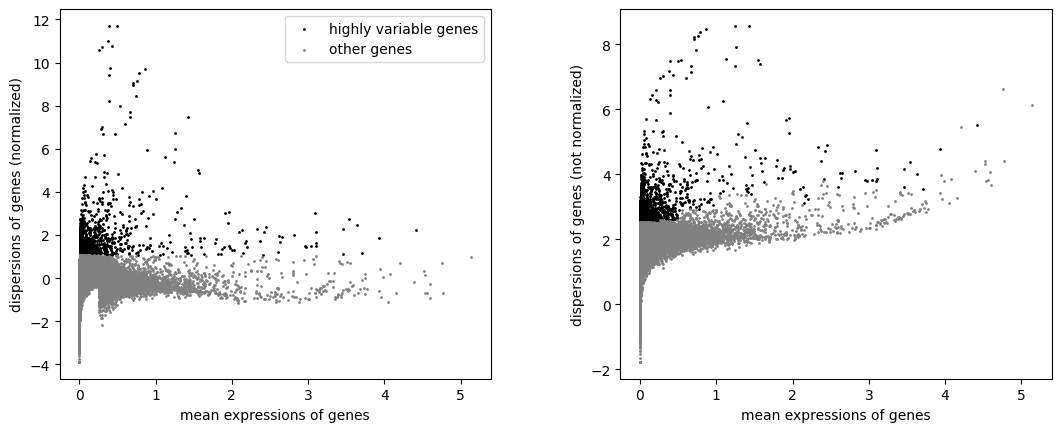

In [15]:
# genes that have high dispersion are variable genes
sc.pl.highly_variable_genes(adata)

In [16]:
# filter the not highly variable genes
adata = adata[:, adata.var.highly_variable]

In [17]:
adata

View of AnnData object with n_obs × n_vars = 3865 × 2000
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [18]:
# removing sequencing artefacts
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt', 'pct_counts_ribo'])

In [19]:
sc.pp.scale(adata, max_value=10)
adata.X.sum(axis=1)

array([-142.84915 , -179.97208 ,  313.82687 , ..., -166.615   ,
         32.937775,  -23.892618], dtype=float32)

In [20]:
#reduce dim data : default 50 pcs
sc.tl.pca(adata, svd_solver='arpack')

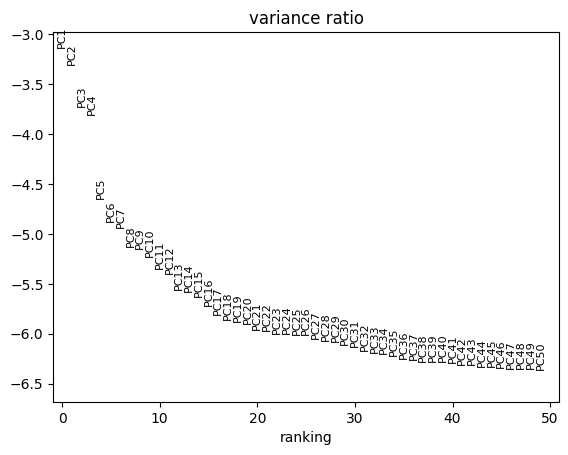

In [21]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 50)

In [22]:
sc.pp.neighbors(adata, n_pcs = 30)

In [23]:
sc.tl.umap(adata)

/home/ouahbi/anaconda3/envs/sc_rnaseq/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


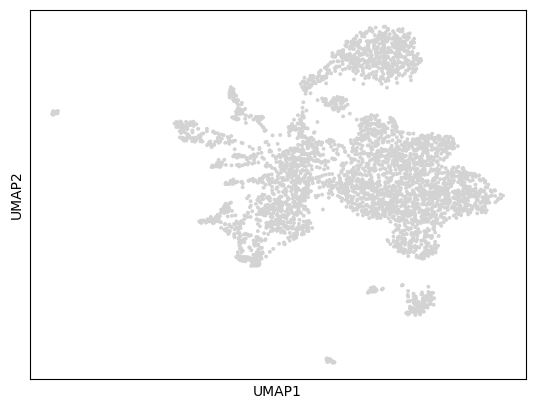

In [24]:
sc.pl.umap(adata)

In [25]:
sc.tl.leiden(adata, resolution = 0.5)

In [26]:
adata.obs['leiden'].value_counts()

leiden
0     746
1     521
2     495
3     465
4     398
5     293
6     226
7     204
8     111
9     111
10     88
11     83
12     68
13     21
14     19
15     16
Name: count, dtype: int64

/home/ouahbi/anaconda3/envs/sc_rnaseq/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/ouahbi/anaconda3/envs/sc_rnaseq/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


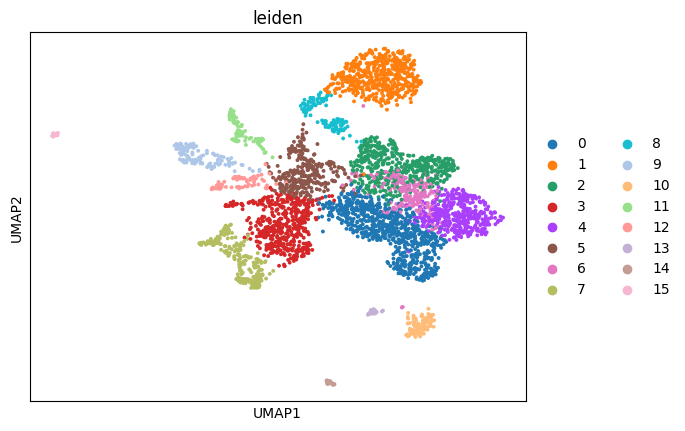

In [27]:
sc.pl.umap(adata, color=['leiden'])

In [28]:
sc.tl.louvain(adata, resolution=0.5)

/home/ouahbi/anaconda3/envs/sc_rnaseq/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/ouahbi/anaconda3/envs/sc_rnaseq/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


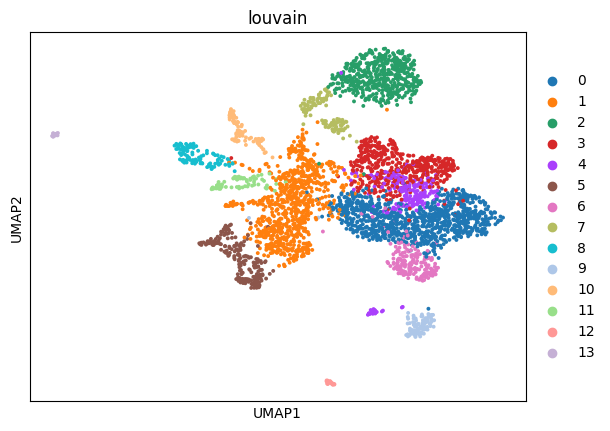

In [29]:
sc.pl.umap(adata, color=['louvain'])

# Integration

In [30]:
adata.obs

,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,n_genes,leiden,louvain
AAACCTGAGAAGCCCA-1,620,991.0,180.0,18.163471,118.0,11.907165,620,6,4
AAACCTGAGGACCACA-1,817,1350.0,84.0,6.222222,32.0,2.370370,817,2,4
AAACCTGAGGCACATG-1,3126,9770.0,349.0,3.572160,713.0,7.297851,3124,7,5
AAACCTGCATGGAATA-1,2084,5728.0,438.0,7.646648,435.0,7.594274,2083,1,2
AAACCTGGTCCAGTTA-1,903,2232.0,0.0,0.000000,663.0,29.704302,903,4,0
...,...,...,...,...,...,...,...,...,...
TTTGTCACATATGAGA-1,2961,14494.0,345.0,2.380295,1254.0,8.651855,2959,7,5
TTTGTCAGTCAGAAGC-1,1415,3086.0,196.0,6.351264,805.0,26.085546,1414,0,0
TTTGTCATCAGGCGAA-1,2369,8779.0,886.0,10.092266,1653.0,18.829023,2368,2,3
TTTGTCATCTACCTGC-1,303,457.0,9.0,1.969365,84.0,18.380743,303,3,1


In [31]:
def pp(csv_path):
    adata = sc.read_10x_h5(f'data/{csv_path}')
    adata.obs['Sample'] = csv_path.split('_')[1].replace('raw','') #'raw_counts/GSM5226574_C51ctr_raw_counts.csv'
    sc.pp.filter_cells(adata, min_genes=200) #get rid of cells with fewer than 200 genes
    #sc.pp.filter_genes(adata, min_cells=3) #get rid of genes that are found in fewer than 3 cells
    adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
    adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values)
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo'], percent_top=None, log1p=False, inplace=True)
    # get unique genes
    adata.var_names_make_unique()
    upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98)
    adata = adata[adata.obs.n_genes_by_counts < upper_lim]
    adata = adata[adata.obs.pct_counts_mt < 20]
    adata = adata[adata.obs.pct_counts_ribo < 40]

    return adata

In [32]:
import os
from tqdm import tqdm
out = []
for file in tqdm(os.listdir('data/')):
    out.append(pp(file))

  0%|                                                                                                                          | 0/11 [00:00<?, ?it/s]/home/ouahbi/anaconda3/envs/sc_rnaseq/lib/python3.11/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/ouahbi/anaconda3/envs/sc_rnaseq/lib/python3.11/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/ouahbi/anaconda3/envs/sc_rnaseq/lib/python3.11/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
  9%|██████████▎                                                                                                       | 1/11 [00:01<00:19,  1.95s/it]/home/o

In [33]:
#adata = sc.concat(out)

In [34]:
for file in os.listdir('data/'):
    print(file.split('_')[1].replace('raw',''))

SC374
SZ16
SZ29
MF24
MF17
MF18
MF21
SZ30
SZ22
SC327
MF19


In [36]:
len(out)

11

In [42]:
adata = sc.concat(out)

/home/ouahbi/anaconda3/envs/sc_rnaseq/lib/python3.11/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [43]:
adata

AnnData object with n_obs × n_vars = 103155 × 31915
    obs: 'Sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'

In [40]:
adata.obs

,Sample,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
AAACCTGAGGGCATGT-1,SC374,1157,1157,1973.0,0.0,0.0,227.0,11.505322
AAACCTGCATGTCGAT-1,SC374,3935,3935,18854.0,0.0,0.0,3159.0,16.755066
AAACCTGTCCCAACGG-1,SC374,4906,4906,27594.0,0.0,0.0,6372.0,23.091976
AAACCTGTCTACCAGA-1,SC374,2587,2587,12763.0,0.0,0.0,3073.0,24.077412
AAACCTGTCTTACCGC-1,SC374,849,849,1779.0,0.0,0.0,283.0,15.907814
...,...,...,...,...,...,...,...,...
TTTGTCATCTATCGCC-1,MF19,277,277,443.0,0.0,0.0,65.0,14.672687
TTTGTCATCTCAAACG-1,MF19,219,219,301.0,0.0,0.0,52.0,17.275747
TTTGTCATCTCAAGTG-1,MF19,243,243,311.0,0.0,0.0,70.0,22.508039
TTTGTCATCTGAGGGA-1,MF19,245,245,353.0,0.0,0.0,58.0,16.430595


In [44]:
sc.pp.filter_genes(adata, min_cells = 10)

/home/ouahbi/anaconda3/envs/sc_rnaseq/lib/python3.11/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [45]:
adata

AnnData object with n_obs × n_vars = 103155 × 21628
    obs: 'Sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'n_cells'

In [46]:
adata.X

<103155x21628 sparse matrix of type '<class 'numpy.float32'>'
	with 87539197 stored elements in Compressed Sparse Row format>

In [47]:


adata.write_h5ad('results/combined.h5ad')

